# Assignment 4
by: _Kevin Adrián Rodríguez Ruiz_ , _Valentina Cobo Paz_, _Juan Sebastián Corredor_

email: karodriguezr@unal.edu.co, vcobop@unal.edu.co, jucorredorr@unal.edu.co

The next functions are intended to hel in common utilites

In [0]:
import urllib.request
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt
import random
import pandas as pd
import json
from glob import glob
from glob import iglob
import re
from collections import Counter

%matplotlib inline

In [2]:
import numpy as np
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.applications import mobilenet
from keras.layers import Dense, Input, Dropout
from keras.models import Model
from keras.optimizers import Adam

from keras import applications
from keras.applications.mobilenet import preprocess_input, decode_predictions
from skimage.transform import resize

original_dataset_path = "drive/My Drive/ml-datasets/multimodal_imdb.hdf5"

Using TensorFlow backend.


In [3]:
#Execute this cell to install your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Downloading dataset
metadata_path = "drive/My Drive/ml-datasets/metadata.npy"
if not os.path.isfile(metadata_path) :
  urllib.request.urlretrieve("http://lisi1.unal.edu.co/mmimdb/metadata.npy", "drive/My Drive/ml-datasets/metadata.npy")
if not os.path.isfile(original_dataset_path) :
  urllib.request.urlretrieve("http://lisi1.unal.edu.co/mmimdb/multimodal_imdb.hdf5", original_dataset_path)

In [0]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         359G   41G  300G  12% /
tmpfs           6.4G     0  6.4G   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
tmpfs           6.4G   12K  6.4G   1% /var/colab
/dev/sda1       365G   44G  322G  12% /opt/bin
shm             6.0G  4.0K  6.0G   1% /dev/shm
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive           359G   57G  302G  16% /content/drive


# Point 1

Design a function able to find the missing characters from a word. The function must work as follows:

```
>>> hangman("pe_p_e")
'people'

>>> hangman("phi__sop_y")
'philosophy'

>>> hangman("si_nif_c_nc_")
'significance'

>>> hangman("kn__l_d_e")
'knowledge'

>>> hangman("inte_r_ga_i_n")
'interrogation'
```

The function must be able to deal with up to 4 unknowns in arbitrary length words. The function must work in a reasonable time (max 30 seconds in a laptop).

In [0]:
# print(len(english_words))
def hangman(word):
  english_words_file = "drive/My Drive/ml-datasets/50k.txt"
  with open(english_words_file, 'r') as words_file:
    english_words = [line.replace('\n', '') for line in words_file.readlines()]
    
  word_regex = f"^{word.replace('_', '.')}$"
  matching_words = [set_word for set_word in english_words if re.match(word_regex, set_word) is not None]
  guessed_word = "no_word_found" if len(matching_words) == 0 else random.choice(matching_words)
  return guessed_word


words= ["pe_p_e", "phi__sop_y", "si_nif_c_nc_", "kn__l_d_e", "inte_r_ga_i_n"]

for word in words:
  hangman_word = hangman(word)
  print(f"hangman('{word}'):\n{hangman_word}\n")


hangman('pe_p_e'):
people

hangman('phi__sop_y'):
philosophy

hangman('si_nif_c_nc_'):
significance

hangman('kn__l_d_e'):
knowledge

hangman('inte_r_ga_i_n'):
interrogation



# 2. Movie poster classification

(a) Direct prediction

$\qquad$i. Download the dataset MM-IMDB from http://lisi1.unal.edu.co/mmimdb/. The dataset includes poster images from movies of different genres. Find the six most frequent genres, chose images only from those genres, filter the images that only belong to one genre. Report the size of the resulting training, development and test datasets per genre.

$\qquad$ii. Use Keras and the MobileNet pre-trained model, to classify the images in the dataset. Construct a confusion matrix that relates the six genres classes with the 10 most frequent classes from ImageNet predicted by the model.

(b) Transfer learning

$\qquad$i. Use the pre-trained MobileNet model as a feature extractor. Create a new model that replaces the top part of MobileNet with two layers of 256 and 6 neurons respectively.

$\qquad$ii. Train the model with the training images from the bird dataset.

$\qquad$iii. Evaluate the performance over the test dataset reporting the results in a confusion matrix. Discuss the results.

(c) Fine tuning

$\qquad$i. Repeat the experiment from the last question, but this time allow all the layers to be trained.

$\qquad$ii. Compare and discuss the results.

In [3]:
# Importing dataset
movies = h5py.File(original_dataset_path, 'r')
list(movies.keys())

['features',
 'genres',
 'images',
 'imdb_ids',
 'sequences',
 'three_grams',
 'vgg_features',
 'word_grams']

In [0]:
# Extracting movies with only one genre
full_movies_genres = np.array(movies['genres'])
full_movies_ids = np.array(movies['imdb_ids'])
full_movies_ids_str = []
for i in range(len(full_movies_ids)):
  full_movies_ids_str.append(full_movies_ids[i].decode('utf-8'))

movies_idx_unigenre = np.where(full_movies_genres.sum(axis=1)==1)[0]


# Extracting the movies of each genre in the six largest genres
genres_sum = full_movies_genres[movies_idx_unigenre].sum(axis = 0)
diccionario = {}
for i in range(len(genres_sum)):
  diccionario[i] = genres_sum[i]
a = sorted(diccionario,key=diccionario.get, reverse=True)[:6]
positions = [] 
for j in movies_idx_unigenre:
  if np.argmax(full_movies_genres[j]) in a:
    positions.append(j)
positions = np.array(positions)  

reshape_movies = []
ids_movies = []
for i in positions:
  ids_movies.append(full_movies_ids_str[i])
  reshape_movies.append(np.swapaxes(movies["images"][i].T,axis1=0,axis2=1))

#print(a[0:6],genres_sum)  

In [5]:
#See the resulting variables
print('Each image has id of type ', type(ids_movies[12]))
print('Each image has shape ', reshape_movies[12].shape)

Each image has id of type  <class 'str'>
Each image has shape  (256, 160, 3)


# Extracting movies with only one genre


full_movies_genres = movies['genres']
movies_idx_unigenre = [[mid, genre] for (mid, genre) in enumerate(full_movies_genres) if genre.sum()==1]
print(len(movies_idx_unigenre))
movies_idx_unigenre[0:10]

# Extraction number of movies for each genre and the six largest genres
genres_dist = np.zeros(23)
for idx in range(23):
  genres_dist[idx]=sum(1 for movie_idx in movies_idx_unigenre if movie_idx[1][idx]==1)

top_genres_dist = genres_dist.copy()
top_genres_dist.sort()
top_genres_dist = top_genres_dist[::-1][0:6]
top_genres_dist

# Extracting the movies that belong to the six largest genres
biggest_genres_idxs = [idx for (idx, size) in enumerate(genres_dist) if size in top_genres_dist]
for idx in biggest_genres_idxs:
  print(genres_dist[idx])
biggest_genres_idxs = np.asarray(biggest_genres_idxs)

movies_top_genres = [genre for genre in movies_idx_unigenre if 1 in genre[1][biggest_genres_idxs]]
print(f"Size of top genres movies: {len(movies_top_genres)}\nSample:\n")
movies_top_genres[0:10]

# Extracting the images of the movies in the largest genres
movies_images = movies['images']
len(movies_images)
movies_top_images =[[movie_genre[0], movies_images[movie_genre[0]]] for movie_genre in movies_top_genres]
len(movies_top_images)

# Saving and Loading the creating dataset  or importing them
filtered_dataset_path = 'drive/My Drive/ml-datasets/movies-images.h5'
if not os.path.isfile(filtered_dataset_path) :
  movies_ids=[movie[0] for movie in movies_top_genres]
  movies_genres=[movie[1] for movie in movies_top_genres]
  movies_images=[movie[1] for movie in movies_top_images]
  hf = h5py.File(filtered_dataset_path, 'w')
  hf.create_dataset('ids', data=movies_ids)
  hf.create_dataset('genres', data=movies_genres)
  hf.create_dataset('images', data=movies_images)
  hf.close()
else :
  movies_filtered = h5py.File(filtered_dataset_path, 'r')
  print(list(movies_filtered.keys()))
  movies_ids = movies_filtered['ids']
  movies_genres = movies_filtered['genres']
  movies_images = movies_filtered['images']

#reshape_movies = np.zeros((5669,256,160,3))
reshape_movies = []
for c in range(len(movies_images)):
  reshape_image = np.swapaxes(movies_images[c].T,axis1=0,axis2=1)
  reshape_movies.append(reshape_image)

filtered_dataset_path = 'drive/My Drive/ml-datasets/movies-images-reshaped.h5'
if not os.path.isfile(filtered_dataset_path) :
    hf = h5py.File(filtered_dataset_path, 'w')
    hf.create_dataset('ids', data=movies_ids)
    hf.create_dataset('genres', data=movies_genres)
    hf.create_dataset('images', data=movies_images)
    hf.close()
else :
    movies_filtered = h5py.File(filtered_dataset_path, 'r')
    print(list(movies_filtered.keys()))
    movies_ids = movies_filtered['ids']
    movies_genres = movies_filtered['genres']
    movies_images = movies_filtered['images']


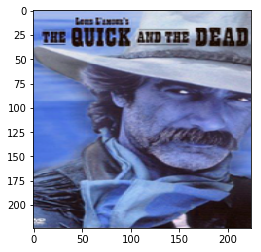

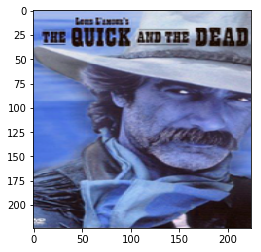

In [14]:
# A function to show movie posters
def show_image(movie_image): 
  img_pil = array_to_img(movie_image)
  plt.imshow(img_pil)
  

#show_image(reshape_movies[1515])

plt.show()
show_image(resize(reshape_movies[0],(224,224),preserve_range=False))

In [0]:
#Images shape
reshape_movies[1515].shape

(256, 160, 3)

# Creating training and test sets
training_fraction = 0.8
movies_idxs = [i for i in range(len(movies_ids))]
random.shuffle(movies_idxs)
training_size = int(len(movies_idxs) * training_fraction)
movies_images_training = np.array([movies_images[m] for m in movies_idxs[0:training_size]])
movies_genres_training = np.array([movies_genres[m] for m in movies_idxs[0:training_size]])
movies_images_test = np.array([movies_images[m] for m in movies_idxs[training_size - 1:len(movies_ids)]])
movies_genres_test = np.array([movies_genres[m] for m in movies_idxs[training_size - 1:len(movies_ids)]])
print(f"Training set size (image): {len(movies_images_training)}")
print(f"Training set size (genre): {len(movies_genres_training)}")
print(f"Test set size (image): {len(movies_images_test)}")
print(f"Test set size (genre): {len(movies_genres_test)}")


In [0]:
with open('drive/My Drive/ml-datasets/split.json') as f:
  splits = json.load(f)

In [0]:
#Create the ids with all the data
train_ids =  pd.DataFrame({'Ids': splits['train']})
dev_ids =  pd.DataFrame({'Ids': splits['dev']})
test_ids =  pd.DataFrame({'Ids': splits['test']})

In [0]:
images_total = pd.DataFrame({'Ids': ids_movies, 'Images': reshape_movies, 'Genres': })

In [0]:
# Reading training and test sets

filtered_dataset_path = 'drive/My Drive/ml-datasets/movies-nn.h5'
if not os.path.isfile(filtered_dataset_path) :
    hf = h5py.File(filtered_dataset_path, 'w')
    hf.create_dataset('ids', data=movies_ids)
    hf.create_dataset('images-train', data=movies_images_training)
    hf.create_dataset('genres-train', data=movies_genres_training)
    hf.create_dataset('images-test', data=movies_images_test)
    hf.create_dataset('genres-test', data=movies_genres_test)
    hf.close()
else :
    movies_filtered = h5py.File(filtered_dataset_path, 'r')
    print(list(movies_filtered.keys()))
    movies_ids = movies_filtered['ids']
    movies_images_training = movies_filtered['images-train']
    movies_genres_training = movies_filtered['genres-train']
    movies_images_test = movies_filtered['images-test']
    movies_genres_test = movies_filtered['genres-test']

In [0]:
# Resizing genres
biggest_genres_idxs 
movies_genres = np.array([movie_genre[biggest_genres_idxs] for movie_genre in movies_genres])
movies_genres_training=np.array([movie_genre[biggest_genres_idxs] for movie_genre in movies_genres_training])
movies_genres_test=np.array([movie_genre[biggest_genres_idxs] for movie_genre in movies_genres_test])
print(f"New shapes:\n Complete: {movies_genres.shape}\n Training: {movies_genres_training.shape}\n Test: {movies_genres_test.shape}")

In [0]:
# Model parameters
img_width, img_height = 160, 256
nb_train_samples = len(movies_images_training)
nb_validation_samples = len(movies_images_test)
epochs = 50
batch_size = 16

In [0]:
# Model parameters
img_width, img_height = 224, 224


In [0]:
class ListTable(list):
    """ Overridden list class which takes a 2-dimensional list of
        the form [[1,2,3],[4,5,6]], and renders an HTML Table in
        IPython Notebook. """

    def _repr_html_(self):
        html = ["<table>"]
        for ridx, row in enumerate(self):
            html.append("<tr>")
            row = list(row)
            for cidx, col in enumerate(row):
                cell = f"<td width='100' style='text-align: center; vertical-align: middle;''> {col}</td>" if ridx != 0 and cidx != 0 else f"<th width='80'>{col}</th>"
                html.append(cell)
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)

# (a) Direct prediction

In [18]:
mobilenet_model = mobilenet.MobileNet(input_shape=(img_height, img_width, 3), alpha=1.0, depth_multiplier=1, dropout=1e-3, include_top=False, weights='imagenet', input_tensor=None, pooling=None)


W0705 13:33:30.065185 140425973294976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0705 13:33:30.156119 140425973294976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0705 13:33:30.197018 140425973294976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0705 13:33:30.255909 140425973294976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0705 13:33:30.257079 1404259732

17227776/17225924 [==============================] - 2s 0us/step


In [19]:
mobilenet_model = mobilenet.MobileNet(alpha=1.0, depth_multiplier=1, dropout=1e-3, include_top=True, weights='imagenet', input_tensor=None, pooling=None)

W0705 13:36:18.830675 140425973294976 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


17227776/17225924 [==============================] - 2s 0us/step


In [0]:
mobilenet_model.summary()

In [0]:
# Softmax layer for classification
softmax_layer = Dense(1000,activation='softmax', name='my_dense_2')
flatten = Flatten()
softmax_out = new_layer2(flatten(mobilenet_model.output))

mobilenet_classes_model = Model(mobilenet_model.input, softmax_out)

mobilenet_classes_model.save("drive/My Drive/ml-datasets/mobilenet-model.h5")

In [0]:
# Predicting movies to MobileNet classes
movies_mn_labels = new_model.predict(movies_images)
movies_mn_labels.shape

[[('n04548362', 'wallet', 0.41003174),
  ('n03223299', 'doormat', 0.23773086),
  ('n03998194', 'prayer_rug', 0.20809858),
  ('n15075141', 'toilet_tissue', 0.040632494),
  ('n03485794', 'handkerchief', 0.03645606)]]

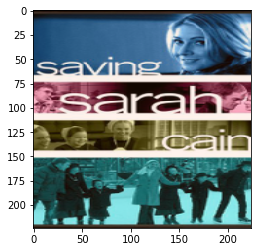

In [46]:
# Predicting movies to MobileNet classes
num=5000
resized=resize(reshape_movies[num],(224,224),preserve_range=True)
movies_mn_labels = mobilenet_model.predict(np.array([resized]))
mn_decoded_movies = decode_predictions(movies_mn_labels, top=5)
show_image(resized)
mn_decoded_movies

[[('n03291819', 'envelope', 0.6427159),
  ('n02692877', 'airship', 0.11509806),
  ('n03598930', 'jigsaw_puzzle', 0.06164258),
  ('n07248320', 'book_jacket', 0.01989325),
  ('n03595614', 'jersey', 0.017550007)]]

In [0]:
# Decoding predicted movies to MobileNet classes

mn_decoded_movies_path="drive/My Drive/ml-datasets/mn-decoded-movies.npy"
np.save(mn_decoded_movies_path, mn_decoded_movies)

In [0]:
# Extracting indexes of most common classes
movies_labels = np.array([label[0][1] for label in mn_decoded_movies])
movies_labels_counter = Counter(movies_labels)
top_most_common = [label for (label, freq) in movies_labels_counter.most_common()[0:10]]
most_common_indexes = np.array([i for i, ml in enumerate(movies_labels) if ml in top_most_common])
print(f"Number of movies in the top 10 MobileNet classes: {len(most_common_indexes)}")

In [0]:
# Confusstion Matrix
confusion_mat = np.zeros((len(biggest_genres_idxs), len(top_most_common)))
genres_idxs = list(biggest_genres_idxs)
for mi in most_common_indexes:
  genre_idx = list(movies_genres[mi]).index(1)
  mnc_idx = top_most_common.index(movies_labels[mi])
  confusion_mat[genre_idx][mnc_idx]+=1

confusion_mat

In [0]:
genres_labels= ['Drama', 'Comedy', 'Romance', 'Thriller', 'Crime', 'Action', 'Adventure', 'Horror', 'Documentary', 'Mystery', 'Sci-Fi', 'Fantasy', 'Family', 'Biography', 'War', 'History', 'Music', 'Animation', 'Musical', 'Western', 'Sport', 'Short', 'Film-Noir']
genres_labels = np.array(genres_labels)[biggest_genres_idxs]
scores_table = ListTable()
scores_table.append(np.append("",top_most_common))
for idx, line in enumerate(confusion_mat):
  scores_table.append(np.append(genres_labels[idx],line))
  
scores_table

# (b) Transfer learning

In [0]:
# Training generator
datagen = ImageDataGenerator(rescale=1. / 255)
datagen.fit(movies_images_training)
generator = datagen.flow(movies_images_training, movies_genres_training, batch_size=32)

In [0]:
# Validation generator
vdatagen = ImageDataGenerator(rescale=1. / 255)
vdatagen.fit(movies_images_test)
vgenerator = vdatagen.flow(movies_images_test, movies_genres_test, batch_size=32)

In [0]:
input_tensor = Input(shape=(img_height, img_width, 3))
base_model = applications.MobileNet(
        include_top=False,
        weights='imagenet',
        input_tensor=input_tensor,
        input_shape=(img_height, img_width, 3),
        pooling='avg')

for layer in base_model.layers:
        layer.trainable = True  # trainable has to be false in order to freeze the layers

op = Dense(256, activation='relu')(base_model.output)
op = Dropout(.25)(op)

output_tensor = Dense(6, activation='softmax')(op)
movies_model = Model(inputs=input_tensor, outputs=output_tensor)

In [0]:
# Training model
movies_model.compile(optimizer=Adam(),loss='categorical_crossentropy',metrics=['categorical_accuracy'])
movies_features_train = movies_model.fit_generator(generator, steps_per_epoch=500, verbose=1, epochs=5)

In [0]:
movies_model.summary()

In [0]:
movies_model.save("drive/My Drive/ml-datasets/movies-model-1.h5")

In [0]:
movies_labels_tl = movies_model.predict(movies_images_test)
movies_labels_tl.shape


In [0]:
# Confusstion Matrix
confusion_mat = np.zeros((len(biggest_genres_idxs), len(biggest_genres_idxs)))
genres_idxs= list(biggest_genres_idxs)
for idx, movie in enumerate(movies_genres_test):
  genre_idx = list(movie).index(1)
  genre_idx_tl = np.argmax(movies_labels_tl[idx])
  confusion_mat[genre_idx][genre_idx_tl]+=1

confusion_mat

In [0]:
movies_labels_tl[55]

In [0]:
genres_labels= ['Drama', 'Comedy', 'Romance', 'Thriller', 'Crime', 'Action', 'Adventure', 'Horror', 'Documentary', 'Mystery', 'Sci-Fi', 'Fantasy', 'Family', 'Biography', 'War', 'History', 'Music', 'Animation', 'Musical', 'Western', 'Sport', 'Short', 'Film-Noir']
genres_labels = np.array(genres_labels)[biggest_genres_idxs]
scores_table = ListTable()
scores_table.append(np.append("", genres_labels))
for idx, line in enumerate(confusion_mat):
  scores_table.append(np.append(genres_labels[idx],line))
  
scores_table

#(c) Fine tuning

In [0]:
# build the MobileNet network
model = applications.MobileNet(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
movies_features_train = model.predict_generator(generator, nb_train_samples // batch_size)

train_features_path="drive/My Drive/ml-datasets/nn_movies-train.npy"
np.save(train_features_path, movies_features_train)